In [1]:
%reload_ext autoreload
%autoreload 2

from IPython.display import HTML

import os
import itertools
import gc
import pickle
import random

import numpy as np
import pandas as pd
import pandas_summary as pds
import seaborn as sns
import xgboost as xgb

from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler, Normalizer, MinMaxScaler
# from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import keras
from keras import initializers
from keras.layers import Input, Embedding, Dense, Flatten, Dropout
from keras.models import Model
from keras.layers.merge import concatenate, multiply
from keras.layers.advanced_activations import LeakyReLU

from zillow import *
from utils import *

import matplotlib.pyplot as plt
%matplotlib inline

/home/terence/anaconda2/envs/deeplearn/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [45]:
zillow_data = DataLoader()
gc.collect()

175

In [49]:
txns = zillow_data.transactions().copy()
txns['transactiondate'] = pd.to_datetime(txns['transactiondate'])
idxs = [ np.argmax(g['transactiondate']) for l, g in txns.groupby(['parcelid']) ]
txns = txns.iloc[idxs]
gc.collect()

In [51]:
props = zillow_data.preprocessed.properties()[['parcelid', 'fips']]
txns = txns.merge(props, how='left', on='parcelid')
txns

,parcelid,logerror,transactiondate,fips
0,10711738,0.0276,2016-08-02,6037
1,10711755,-0.0182,2016-08-02,6037
2,10711805,-0.1009,2016-05-03,6037
3,10711816,-0.0121,2016-04-05,6037
4,10711858,-0.0481,2016-07-15,6037
5,10711910,0.2897,2016-08-30,6037
6,10712086,0.0040,2016-02-12,6037
7,10712162,-0.0121,2016-09-27,6037
8,10712163,0.0139,2016-08-23,6037
9,10712195,-0.0450,2016-05-11,6037


In [53]:
txns = zillow_data.preprocessed.split_date(txns)
txns = txns.merge(zillow_data.preprocessed.error_trend(), how='left', on=['fips', 'transaction_month'])
txns

,parcelid,logerror,fips,transaction_month,logerror_fips_month_ave,logerror_abs_fips_month_ave,logerror_fips_month_std,logerror_abs_fips_month_std,logerror_month_ave,logerror_abs_month_ave,logerror_month_std,logerror_abs_month_std
0,10711738,0.0276,6037,8,0.010909,0.071703,0.024437,0.019426,0.010952,0.065576,0.022828,0.018666
1,10711755,-0.0182,6037,8,0.010909,0.071703,0.024437,0.019426,0.010952,0.065576,0.022828,0.018666
2,10711805,-0.1009,6037,5,0.011244,0.075842,0.030359,0.024723,0.011337,0.069219,0.027067,0.022403
3,10711816,-0.0121,6037,4,0.011356,0.077222,0.032332,0.026489,0.011466,0.070433,0.028481,0.023649
4,10711858,-0.0481,6037,7,0.011021,0.073083,0.026411,0.021191,0.011080,0.066790,0.024241,0.019911
5,10711910,0.2897,6037,8,0.010909,0.071703,0.024437,0.019426,0.010952,0.065576,0.022828,0.018666
6,10712086,0.0040,6037,2,0.011579,0.079981,0.036280,0.030021,0.011723,0.072862,0.031307,0.026141
7,10712162,-0.0121,6037,9,0.010797,0.070323,0.022464,0.017660,0.010823,0.064361,0.021415,0.017420
8,10712163,0.0139,6037,8,0.010909,0.071703,0.024437,0.019426,0.010952,0.065576,0.022828,0.018666
9,10712195,-0.0450,6037,5,0.011244,0.075842,0.030359,0.024723,0.011337,0.069219,0.027067,0.022403


In [55]:
txns['logerror_scaled'] = (txns['logerror'] - txns['logerror_fips_month_ave']) / txns['logerror_fips_month_std'].apply(np.sqrt)
txns

,parcelid,logerror,fips,transaction_month,logerror_fips_month_ave,logerror_abs_fips_month_ave,logerror_fips_month_std,logerror_abs_fips_month_std,logerror_month_ave,logerror_abs_month_ave,logerror_month_std,logerror_abs_month_std,logerror_scaled
0,10711738,0.0276,6037,8,0.010909,0.071703,0.024437,0.019426,0.010952,0.065576,0.022828,0.018666,0.106773
1,10711755,-0.0182,6037,8,0.010909,0.071703,0.024437,0.019426,0.010952,0.065576,0.022828,0.018666,-0.186207
2,10711805,-0.1009,6037,5,0.011244,0.075842,0.030359,0.024723,0.011337,0.069219,0.027067,0.022403,-0.643628
3,10711816,-0.0121,6037,4,0.011356,0.077222,0.032332,0.026489,0.011466,0.070433,0.028481,0.023649,-0.130446
4,10711858,-0.0481,6037,7,0.011021,0.073083,0.026411,0.021191,0.011080,0.066790,0.024241,0.019911,-0.363785
5,10711910,0.2897,6037,8,0.010909,0.071703,0.024437,0.019426,0.010952,0.065576,0.022828,0.018666,1.783412
6,10712086,0.0040,6037,2,0.011579,0.079981,0.036280,0.030021,0.011723,0.072862,0.031307,0.026141,-0.039792
7,10712162,-0.0121,6037,9,0.010797,0.070323,0.022464,0.017660,0.010823,0.064361,0.021415,0.017420,-0.152770
8,10712163,0.0139,6037,8,0.010909,0.071703,0.024437,0.019426,0.010952,0.065576,0.022828,0.018666,0.019135
9,10712195,-0.0450,6037,5,0.011244,0.075842,0.030359,0.024723,0.011337,0.069219,0.027067,0.022403,-0.322801


In [123]:
txns[['parcelid', 'fips', 'logerror_scaled']].to_pickle('zillow/logerror_scaled.pkl')

In [155]:
txns = pd.read_pickle('zillow/logerror_scaled.pkl')

In [156]:
subm = pd.DataFrame()
subm['ParcelId'] = txns['parcelid']
months = [10, 11, 12, 22, 23, 24]
dates = ['201610', '201611', '201612', '201710', '201711', '201712']
for month, date in zip(months, dates):
    txns['transaction_month'] = month
    mrgd = txns.merge(zillow_data.preprocessed.error_trend(), how='left', on=['fips', 'transaction_month'])
    subm[date] = mrgd['logerror_scaled'] * mrgd['logerror_month_std'].apply(np.sqrt) + mrgd['logerror_month_ave']
subm.to_pickle('zillow/subm_w_txn.pkl')
subm.shape

(90150, 7)

In [154]:
best_subm = pd.read_csv('zillow/submission.best.csv.gz')

In [157]:
subm = subm.set_index('ParcelId')
best_subm = best_subm.set_index('ParcelId')
subm = subm.combine_first(best_subm)
subm.head()

,201610,201611,201612,201710,201711,201712
ParcelId,,,,,,
10711725,0.0098,0.0095,0.0095,0.0091,0.0091,0.0091
10711726,0.0113,0.0111,0.0110,0.0106,0.0106,0.0106
10711727,0.0103,0.0100,0.0100,0.0091,0.0091,0.0091
10711728,0.0111,0.0109,0.0109,0.0104,0.0104,0.0104
10711729,0.0112,0.0110,0.0110,0.0105,0.0105,0.0105


In [158]:
subm.to_csv('zillow/subm_hybrid.csv.gz', index=True, float_format='%.4f', compression='gzip')

In [146]:
props = zillow_data.preprocessed.properties()[['parcelid', 'fips']]
display(props.shape)
props = props[~props.parcelid.isin(subm.ParcelId)]
props = props[~(props.fips == '')].reset_index()
props.shape

(2985217, 2)

(2883630, 3)

In [147]:
subm = pd.DataFrame()
subm['ParcelId'] = props['parcelid']
months = [10, 11, 12, 22, 23, 24]
dates = ['201610', '201611', '201612', '201710', '201711', '201712']
for month, date in zip(months, dates):
    props['transaction_month'] = month
    mrgd = props.merge(zillow_data.preprocessed.error_trend(), how='left', on=['fips', 'transaction_month'])
    subm[date] = mrgd['logerror_fips_month_ave'].copy()
    display(subm[date].isnull().any())
subm.to_pickle('zillow/subm_w_fips.pkl')
subm.shape

False

False

False

False

False

False

(2883630, 7)

In [148]:
props = zillow_data.preprocessed.properties()[['parcelid', 'fips']]
props = props[~props.parcelid.isin(subm.ParcelId)]
props = props[props.fips == ''].reset_index()
props.shape

(11437, 3)

In [149]:
gc.collect()
subm = pd.DataFrame()
subm['ParcelId'] = props['parcelid']
months = [10, 11, 12, 22, 23, 24]
dates = ['201610', '201611', '201612', '201710', '201711', '201712']
for month, date in zip(months, dates):
    props['transaction_month'] = month
    mrgd = props.merge(zillow_data.preprocessed.error_trend(), how='left', on=['transaction_month'])
    subm[date] = mrgd['logerror_month_ave']
subm.to_pickle('zillow/subm_w_notn.pkl')
subm.shape

(11437, 7)

In [150]:
gc.collect()
subm = pd.read_pickle('zillow/subm_w_txn.pkl')
subm = subm.append(pd.read_pickle('zillow/subm_w_fips.pkl'))
subm = subm.append(pd.read_pickle('zillow/subm_w_notn.pkl'))
subm.to_csv('zillow/subm_all.csv.gz', index=False, float_format='%.4f', compression='gzip')
subm.shape

(2985217, 7)

In [151]:
subm[2886423:2886424]

,ParcelId,201610,201611,201612,201710,201711,201712
2796273,11174907,0.010685,0.010574,0.010462,0.009344,0.009233,0.009121


In [86]:
submission = pd.read_csv('zillow/submission.csv.gz')
submission.shape

(2985217, 7)

In [62]:
trend = zillow_data.preprocessed.error_trend()
trend[trend.transaction_month==24]

,transaction_month,fips,logerror_fips_month_ave,logerror_abs_fips_month_ave,logerror_fips_month_std,logerror_abs_fips_month_std,logerror_month_ave,logerror_abs_month_ave,logerror_month_std,logerror_abs_month_std
23,24,6037,0.009121,0.049628,-0.007143,-0.008829,0.008895,0.046146,0.000218,-0.001269
47,24,6059,0.006321,0.038907,0.016717,0.015590,0.008895,0.046146,0.000218,-0.001269
71,24,6111,0.015657,0.045334,0.005238,0.003836,0.008895,0.046146,0.000218,-0.001269


In [3]:
vals = describe_values(zillow_data.properties())
cols_high_missing = set(vals.loc[vals['missing %'] > 50]['column'])
display(vals)
cols_high_missing

/home/terence/anaconda2/envs/deeplearn/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,column,dtype,sample,unique len,missing %
57,parcelid,int64,"[10754147, 10759547, 10843547]",2985217,0.000000
56,airconditioningtypeid,float64,"[1.0, 3.0, 5.0]",8,72.815410
55,architecturalstyletypeid,float64,"[2.0, 3.0, 5.0]",9,99.796966
54,basementsqft,float64,"[20.0, 24.0, 25.0]",752,99.945465
53,bathroomcnt,float64,"[0.0, 0.5, 1.0]",38,0.383959
52,bedroomcnt,float64,"[0.0, 1.0, 2.0]",22,0.383557
51,buildingclasstypeid,float64,"[1.0, 2.0, 3.0]",6,99.576949
50,buildingqualitytypeid,float64,"[1.0, 2.0, 3.0]",13,35.063749
49,calculatedbathnbr,float64,"[1.0, 1.5, 2.0]",35,4.318346
48,decktypeid,float64,"[66.0, nan]",2,99.427311


{'airconditioningtypeid',
 'architecturalstyletypeid',
 'basementsqft',
 'buildingclasstypeid',
 'decktypeid',
 'finishedfloor1squarefeet',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'fireplacecnt',
 'fireplaceflag',
 'garagecarcnt',
 'garagetotalsqft',
 'hashottuborspa',
 'numberofstories',
 'poolcnt',
 'poolsizesum',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'regionidneighborhood',
 'storytypeid',
 'taxdelinquencyflag',
 'taxdelinquencyyear',
 'threequarterbathnbr',
 'typeconstructiontypeid',
 'yardbuildingsqft17',
 'yardbuildingsqft26'}

# Training & Testing w/ XGBoost

In [4]:
def remove_outliers(X, y):
    f = np.abs(y-y.mean())<=(3*y.std())
    return X[f], y[f]

def train_test_split(X, y, month=9):
    c = X.transaction_month
    return X[c < month], X[c == month], X[c > month], y[c < month], y[c == month], y[c > month]


def adapt_for_xgb(df, dropcols=set()):
    mustdropcols = set([
                'propertyzoningdesc', 
                'propertycountylandusecode', 
                'censustractandblock', 
                'rawcensustractandblock',
                'parcelid',
               ])
    
    mustdropcols = mustdropcols | set(dropcols)
    df = df.drop(mustdropcols, axis=1)
    
    for c in df.columns:
        if df[c].dtype.name == 'object':
            df[c] = df[c].replace('',0).astype(np.float32)
    
    return df

def xgb_train(params=None, dropcols=set()):
    train = zillow_data.preprocessed.training()
    train = adapt_for_xgb(train, dropcols)
    
    X = train.drop(['logerror', 'logerror_abs'], axis=1)
    y = train['logerror']
    
    del train; gc.collect()
    
    x_train, x_valid, x_test, y_train, y_valid, y_test = train_test_split(X, y)
#     x_train, y_train = remove_outliers(x_train, y_train)

    d_train = xgb.DMatrix(x_train, label=y_train, silent=True)
    d_valid = xgb.DMatrix(x_valid, label=y_valid, silent=True)
    d_test = xgb.DMatrix(x_test, label=y_test, silent=True)
    
    del x_train, x_valid, x_test; gc.collect()

    if not params:
        params = {
            'eta': 0.005,
            'objective': 'reg:linear',
            'eval_metric': 'mae',
            'max_depth': 3,
            'silent': 1,
            'subsample': 0.3,
            'colsample_bytree': 0.1,
            'min_child_weight': 4,
            'lambda': 2,
        }

    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    clf = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=100, verbose_eval=False)
    mae = mean_absolute_error(y_test, clf.predict(d_test))
    print ("Test MAE: ", mae)
    print ("\n")
    
    amea = (d_valid.num_row() * float(clf.attr('best_score'))) + (d_test.num_row() * mae)
    amea = amea / (d_valid.num_row() + d_test.num_row())
    
    del d_train, d_valid, d_test; gc.collect()
    
    return clf, mae, amea


def xgb_predict(clf, dropcols=set()):
    # build the test set
    subm = pd.DataFrame()
    subm['ParcelId'] = zillow_data.preprocessed.properties()['parcelid']
    months = [10, 11, 12, 22, 23, 24]
    dates = ['201610', '201611', '201612', '201710', '201711', '201712']
#     months = [10]
#     dates = ['201610']
    for month, date in zip(months, dates):
        print('Predicting...', date)

        merged = zillow_data.preprocessed.prediction(month)
        merged = adapt_for_xgb(merged, dropcols)
        gc.collect()
        
        dm_test = xgb.DMatrix(merged)
        del merged; gc.collect()
        
        subm[date] = clf.predict(dm_test)
        del dm_test; gc.collect()
    
    subm.to_csv('zillow/submission.csv.gz', index=False, float_format='%.4f', compression='gzip')
    return subm

    
def xgb_importance(clf):
    importance = clf.get_fscore()
    importance = sorted(importance.items(), key=lambda x: x[1])

    df = pd.DataFrame(importance, columns=['feature', 'fscore'])
    df['fscore'] = df['fscore'] / df['fscore'].sum()

    df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
    plt.title('XGBoost Feature Importance')
    plt.xlabel('relative importance');
    return df
    
# train a model
def train_predict(params=None, predict=False, plot_imp=False, dropcols=set()):
    clf, mae, _ = xgb_train(params, dropcols)
    subm = None
    if predict:
        subm = xgb_predict(clf, dropcols)
    imp = None
    if plot_imp:
        imp = xgb_importance(clf)
    return clf, subm, imp

[0]	train-mae:0.495975	valid-mae:0.489731
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 100 rounds.
[20]	train-mae:0.450385	valid-mae:0.444182
[40]	train-mae:0.409326	valid-mae:0.403111
[60]	train-mae:0.372334	valid-mae:0.366105
[80]	train-mae:0.339041	valid-mae:0.332795
[100]	train-mae:0.309074	valid-mae:0.302811
[120]	train-mae:0.282161	valid-mae:0.275907
[140]	train-mae:0.257991	valid-mae:0.251736
[160]	train-mae:0.236293	valid-mae:0.230072
[180]	train-mae:0.216854	valid-mae:0.210661
[200]	train-mae:0.19944	valid-mae:0.193227
[220]	train-mae:0.183873	valid-mae:0.177647
[240]	train-mae:0.169988	valid-mae:0.163763
[260]	train-mae:0.157589	valid-mae:0.151371
[280]	train-mae:0.146505	valid-mae:0.1403
[300]	train-mae:0.136656	valid-mae:0.130534
[320]	train-mae:0.12793	valid-mae:0.121819
[340]	train-mae:0.120187	valid-mae:0.114116
[360]	train-mae:0.113401	valid-mae:0.107394
[380]	train-mae:0.107383	valid

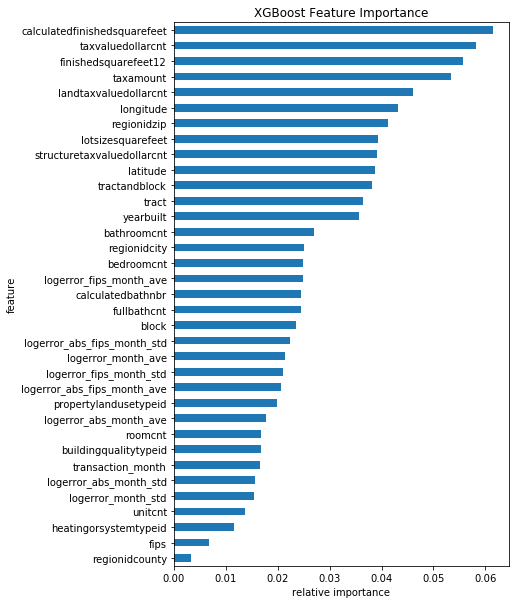

In [5]:
gc.collect()
clf, subm, imp = train_predict(params=params, predict=True, plot_imp=True)

In [11]:
def recursive_feature_selection(cols, dropcols=None, reverse=False):
    if dropcols == None:
        dropcols = from_pickle('zillow/dropcols.pkl')
    if dropcols == None:
        dropcols = set()
    cols = set(zillow_data.preprocessed.properties().columns)
    cols = cols - dropcols
    _, _, mae = xgb_train(dropcols=dropcols)
    mae_best = mae
    mae_best_pass = mae

    i = 0
    while True:
        i += 1
        print ('Pass: ', i)
        for c in cols:
            if reverse:
                clf, _, mae = xgb_train(dropcols=dropcols - set([c]))
            else:
                clf, _, mae = xgb_train(dropcols=dropcols | set([c]))
    #         mae = float(clf.attr('best_score'))
            if mae < mae_best_pass:
                mae_best_pass = mae
                dropc = c
        if mae_best_pass >= mae_best:
            print ('No more improvements')
            break
        else:
            print ('Dropping: ', dropc)
            print ('Best MAE: ', mae_best_pass)
            if reverse:
                cols.add(dropc)
                dropcols.remove(dropc)
            else:
                cols.remove(dropc)
                dropcols.add(dropc)
            to_pickle(dropcols, 'zillow/dropcols.pkl')
            mae_best = mae_best_pass
    print (dropcols)
    

In [12]:
cols = set(zillow_data.preprocessed.properties().columns)
recursive_feature_selection(cols, cols_high_missing)

Test MAE:  0.0653876751953


Pass:  1
Test MAE:  0.0654294137079


Test MAE:  0.0654386811155


Test MAE:  0.0653876751953


Test MAE:  0.0654467311571


Test MAE:  0.0654056956559


Test MAE:  0.0654260554691


Test MAE:  0.0653988161914


Test MAE:  0.0653852105944


Test MAE:  0.0654602403167


Test MAE:  0.0654362458317


Test MAE:  0.0654096593634


Test MAE:  0.0653876751953


Test MAE:  0.0654056632569


Test MAE:  0.0654031282975


Test MAE:  0.0653876751953


Test MAE:  0.0654368886059


Test MAE:  0.0654323326436


Test MAE:  0.0654157145567


Test MAE:  0.0654750442758


Test MAE:  0.0653876751953


Test MAE:  0.0653948321405


Test MAE:  0.0654382209681


Test MAE:  0.0653965353897


Test MAE:  0.0654389288676


Test MAE:  0.0654514908796


Test MAE:  0.0654707177623


Test MAE:  0.0654344766768


Test MAE:  0.0654345551071


Test MAE:  0.0653876751953


Test MAE:  0.0654043726287


Test MAE:  0.0654434310994


Test MAE:  0.0654396346021


Dropping:  roomcnt
Best MAE:  0.06

Test MAE:  0.0653948321405


Predicting... 201610
Predicting... 201611
Predicting... 201612
Predicting... 201710
Predicting... 201711
Predicting... 201712


(<xgboost.core.Booster at 0x7f7942944940>,
           ParcelId    201610    201611    201612    201710    201711    201712
 0         10754147  0.266570  0.262175  0.262822  0.266322  0.266322  0.266322
 1         10759547  0.101209  0.100985  0.101632  0.103284  0.103284  0.103284
 2         10843547  0.051652  0.051960  0.051970  0.051149  0.051149  0.051149
 3         10859147  0.031234  0.030798  0.030808  0.028713  0.028713  0.028713
 4         10879947  0.020574  0.020123  0.020134  0.018155  0.018155  0.018155
 5         10898347  0.016841  0.016369  0.016380  0.014401  0.014401  0.014401
 6         10933547  0.009026  0.008806  0.008817  0.007582  0.007582  0.007582
 7         10940747  0.018067  0.017623  0.017633  0.015707  0.015707  0.015707
 8         10954547  0.259561  0.257770  0.258417  0.262050  0.262050  0.262050
 9         10976347  0.023443  0.022990  0.023000  0.021063  0.021063  0.021063
 10        11073947  0.027713  0.027256  0.027266  0.025247  0.025247  0.0252

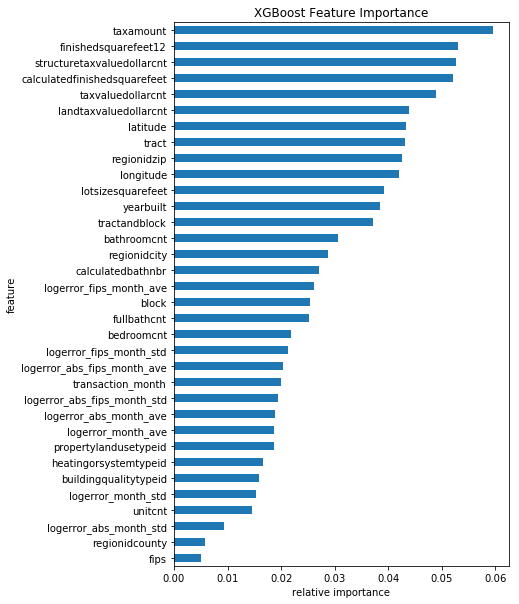

In [5]:
dropcols = cols_high_missing
dropcols.add('roomcnt')
train_predict(predict=True, plot_imp=True, dropcols=dropcols)

In [ ]:
dropcols = ['fips', 'tractandblock', 'roomcnt', 'bedroomcnt', 'taxdelinquencyflag']
train_predict(params=params, predict=True, plot_imp=True, dropcols=dropcols)

Test MAE:  0.0653583500561


Predicting... 201610
Predicting... 201611
Predicting... 201612
Predicting... 201710
Predicting... 201711
Predicting... 201712


## Best MAE = 0.0653576002076

In [10]:
from zillow import DataLoader

zillow_data = DataLoader()
gc.collect()
mrg = zillow_data.preprocessed.training()

/home/terence/Workspace/dl_projects/zillow.py:27: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  self.preprocess_properties()


In [11]:
cols = [c for c in mrg.columns if c.startswith('logerror')] + ['transaction_month', 'fips', 'parcelid']
describe_values(mrg.loc[:, cols])

,column,dtype,sample,unique len,missing %
12,logerror,float64,"[-4.605, -4.51, -3.194]",1894,0.0
11,logerror_abs,float64,"[0.0, 0.001, 0.002]",1821,0.0
10,logerror_fips_month_ave,float64,"[0.00861058108251, 0.00880136498563, 0.0089921...",36,0.0
9,logerror_abs_fips_month_ave,float64,"[0.0491330887854, 0.0499852814109, 0.050837474...",36,0.0
8,logerror_fips_month_std,float64,"[0.0165423635161, 0.018256859187, 0.01838521266]",36,0.0
7,logerror_abs_fips_month_std,float64,"[0.012361789404, 0.0141277248239, 0.0158936602...",36,0.0
6,logerror_month_ave,float64,"[0.0104377115365, 0.0105662526959, 0.010694793...",12,0.0
5,logerror_abs_month_ave,float64,"[0.0607183452893, 0.0619327135667, 0.063147081...",12,0.0
4,logerror_month_std,float64,"[0.0171757291218, 0.0185888317276, 0.020001934...",12,0.0
3,logerror_abs_month_std,float64,"[0.0136818444441, 0.0149277585224, 0.016173672...",12,0.0


In [12]:
zillow_data.preprocessed.logerror_month
# plt.plot(dl.logerror_month['transaction_month'], dl.logerror_month['logerror_month_ave'])

,transaction_month,fips,logerror_fips_month_ave,logerror_abs_fips_month_ave,logerror_fips_month_std,logerror_abs_fips_month_std,logerror_month_ave,logerror_abs_month_ave,logerror_month_std,logerror_abs_month_std
0,1,6037,0.011691,0.081361,0.038254,3.178708e-02,0.011852,0.074076,0.032720,0.027387
1,2,6037,0.011579,0.079981,0.036280,3.002114e-02,0.011723,0.072862,0.031307,0.026141
2,3,6037,0.011468,0.078601,0.034306,2.825521e-02,0.011595,0.071648,0.029894,0.024895
3,4,6037,0.011356,0.077222,0.032332,2.648927e-02,0.011466,0.070433,0.028481,0.023649
4,5,6037,0.011244,0.075842,0.030359,2.472334e-02,0.011337,0.069219,0.027067,0.022403
5,6,6037,0.011132,0.074462,0.028385,2.295740e-02,0.011209,0.068005,0.025654,0.021157
6,7,6037,0.011021,0.073083,0.026411,2.119147e-02,0.011080,0.066790,0.024241,0.019911
7,8,6037,0.010909,0.071703,0.024437,1.942553e-02,0.010952,0.065576,0.022828,0.018666
8,9,6037,0.010797,0.070323,0.022464,1.765960e-02,0.010823,0.064361,0.021415,0.017420
9,10,6037,0.010685,0.068943,0.020490,1.589366e-02,0.010695,0.063147,0.020002,0.016174


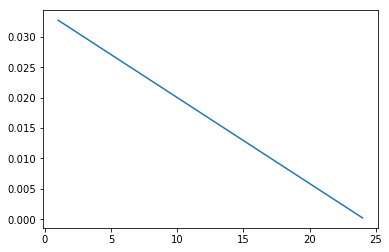

In [29]:
dl.logerror_month
plt.plot(dl.logerror_month['transaction_month'], dl.logerror_month['logerror_month_std'])

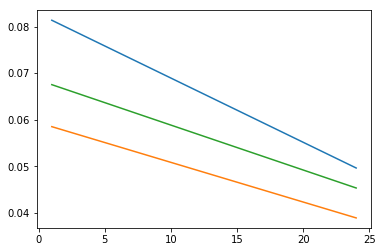

In [27]:
dl.logerror_fips_month
for f in dl.logerror_fips_month['fips'].unique():
    df = dl.logerror_fips_month[dl.logerror_fips_month['fips'] == f]
    plt.plot(df['transaction_month'], df['logerror_abs_fips_month_ave'])

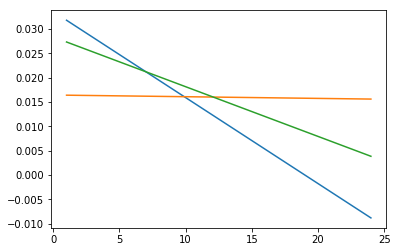

In [28]:
dl.logerror_fips_month
for f in dl.logerror_fips_month['fips'].unique():
    df = dl.logerror_fips_month[dl.logerror_fips_month['fips'] == f]
    plt.plot(df['transaction_month'], df['logerror_abs_fips_month_std'])

In [13]:
from zillow import *

In [2]:
zillow_data = DataLoader()
gc.collect()

0

In [15]:
nn = NeuralNet(zillow_data.preprocessed)
gc.collect()
nn.train(epochs=1)

/home/terence/Workspace/dl_projects/zillow.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  e.loc[:, ['logerror_abs_month_std']] = e['logerror_abs_month_std'].apply(np.sqrt)
/home/terence/anaconda2/envs/deeplearn/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype bool was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/terence/anaconda2/envs/deeplearn/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(8542, 69) (8542, 2)
Train on 72158 samples, validate on 9575 samples
Epoch 1/1
72158/72158 [==============================] - 9s - loss: 0.0922 - val_loss: 0.0666
[[ 0.00269953]
 [ 0.00712079]
 [ 0.00309816]
 ..., 
 [ 0.00803885]
 [ 0.00170472]
 [ 0.00250346]]


0.066149258181493198

In [16]:
nn.train(epochs=1)

Train on 72158 samples, validate on 9575 samples
Epoch 1/1
72158/72158 [==============================] - 5s - loss: 0.0690 - val_loss: 0.0663
[[ 0.00999435]
 [ 0.00831455]
 [ 0.00657735]
 ..., 
 [ 0.00849888]
 [ 0.00280804]
 [ 0.00428695]]


0.065746170461865261

In [17]:
nn.train(epochs=5)

Train on 72158 samples, validate on 9575 samples
Epoch 1/5
72158/72158 [==============================] - 5s - loss: 0.0688 - val_loss: 0.0662
Epoch 2/5
72158/72158 [==============================] - 5s - loss: 0.0687 - val_loss: 0.0668
Epoch 3/5
72158/72158 [==============================] - 5s - loss: 0.0686 - val_loss: 0.0664
Epoch 4/5
72158/72158 [==============================] - 5s - loss: 0.0686 - val_loss: 0.0664
Epoch 5/5
72158/72158 [==============================] - 5s - loss: 0.0686 - val_loss: 0.0671
[[ 0.00187066]
 [ 0.00102693]
 [-0.00124767]
 ..., 
 [-0.00083342]
 [-0.00395069]
 [-0.00099632]]


0.066789928151806524

# Prepare Data Mappers

In [ ]:
tx = 'transactiondate'

train = dl.get_training()
train = split_date(train, tx)
train = train.merge(procd, how='left', on='parcelid')
train = add_age(train)

gc.collect()

x = train.drop(['logerror', tx] + dropcols, axis=1)
# x['parcelid'] = x['parcelid'].astype(CATEGORY_TYPE)
# procd['parcelid'] = procd['parcelid'].astype(CATEGORY_TYPE)
y = train['logerror']

dte_cols = [ tx+'_year', tx+'_month', 'age']
cat_cols = [ c for c in x.columns if x[c].dtype.name == 'object' and c not in dte_cols ]
con_cols = [ c for c in x.columns if x[c].dtype.name != 'object' and c not in dte_cols ]

In [ ]:
dte_maps = [([c], StandardScaler(with_mean=False)) for c in dte_cols]
display(len(dte_maps))
cat_maps = [(c, LabelEncoder()) for c in cat_cols]
display(len(cat_maps))
con_maps = [([c], StandardScaler(with_mean=False)) for c in con_cols]
display(len(con_maps))

In [ ]:
dte_mapper = DataFrameMapper(dte_maps)
dte_map_fit = dte_mapper.fit(x)

In [ ]:
cat_mapper = DataFrameMapper(cat_maps)
cat_map_fit = cat_mapper.fit(procd)
# display(cat_map_fit.features)

In [ ]:
con_mapper = DataFrameMapper(con_maps)
con_map_fit = con_mapper.fit(x)
# display(con_map_fit.features)

In [ ]:
to_pickle(dte_map_fit, 'zillow/dte_maps.pkl')
to_pickle(cat_map_fit, 'zillow/cat_maps.pkl')
to_pickle(con_map_fit, 'zillow/con_maps.pkl')

In [ ]:
dte_map_fit = from_pickle('zillow/dte_maps.pkl')
cat_map_fit = from_pickle('zillow/cat_maps.pkl')
con_map_fit = from_pickle('zillow/con_maps.pkl')

# Build the NN Model

In [ ]:
embsz = 16

def categorical_input(fname, fclasses):
    vocsz = len(fclasses)
#     print(vocsz)
    inp = Input((1,), dtype='int64', name=fname+'_inp')
    out = Embedding(vocsz, embsz, input_length=1, embeddings_initializer='random_uniform')(inp)
    out = Flatten(name=fname+'_flt')(out)
    if fname == 'parcelid':
        out = Dropout(0.9)(out)
    out = Dense(1, name=fname+'_den', activation='relu')(out)
    return inp, out

def continuous_input(fname):
    inp = Input((1,), dtype='float32', name=fname+'_inp')
    out = Dense(1, name=fname+'_den', activation='relu')(inp)
    return inp, out    

cat_in = [ categorical_input(f[0], f[1].classes_) for f in cat_map_fit.features ]
con_in = [ continuous_input(f[0][0]) for f in con_map_fit.features ] +\
[ continuous_input(f[0][0]) for f in dte_map_fit.features ]

den = concatenate([ o for _, o in cat_in ] + [ o for _, o in con_in ])
den = Dropout(0.05)(den)
den = Dense(256, activation=LeakyReLU(), kernel_initializer='random_uniform')(den)
den = Dense(256, activation=LeakyReLU(), kernel_initializer='random_uniform')(den)
den = Dense(1, activation='softplus')(den)
den = Dense(1, activation='linear')(den)
# out = multiply([tanh, relu])

model = Model(inputs=[ i for i, _ in cat_in ] + [ i for i, _ in con_in ], outputs=[den])
model.compile('adam', 'mean_absolute_error')
model.summary()

In [ ]:
def transform(df, mappers):
    mapped = []
    for m, dtype in mappers:
        mapped.append(m.transform(df).astype(dtype))
    return np.concatenate(mapped, axis=1)

def split(df):
    return np.split(df, df.shape[1], axis=1)

In [ ]:
mappers = [(cat_map_fit, 'int64'), (con_map_fit, 'float32'), (dte_map_fit, 'float32')]

x_train = transform(x, mappers)
x_train = split(x_train)

y_train = y

In [ ]:
hist = model.fit(x_train, y_train, batch_size=256, epochs=5, verbose=1, validation_split=0.1, shuffle=True)

# Use a small sample for testing the NN

In [ ]:
# get a sample
x_train, x_valid, x_test, y_train, y_valid, y_test = train_test_split(x, y, 2)

In [ ]:
mappers = [(cat_map_fit, 'int64'), (con_map_fit, 'float32'), (dte_map_fit, 'float32')]

x_train = transform(x_train, mappers)
x_valid = transform(x_valid, mappers)
x_test = transform(x_test, mappers)

x_train = split(x_train)
x_valid = split(x_valid)
x_test = split(x_test)

gc.collect()

In [ ]:
to_pickle(x_train, 'zillow/x_train.pkl')
to_pickle(x_valid, 'zillow/x_valid.pkl')
to_pickle(x_test, 'zillow/x_test.pkl')

to_pickle(y_train, 'zillow/y_train.pkl')
to_pickle(y_valid, 'zillow/y_valid.pkl')
to_pickle(y_test, 'zillow/y_test.pkl')

In [ ]:
x_train = from_pickle('zillow/x_train.pkl')
x_valid = from_pickle('zillow/x_valid.pkl')
x_test = from_pickle('zillow/x_test.pkl')

y_train = from_pickle('zillow/y_train.pkl')
y_valid = from_pickle('zillow/y_valid.pkl')
y_test = from_pickle('zillow/y_test.pkl')

In [ ]:
hist = model.fit(x_train, y_train, batch_size=128, epochs=1,
                 verbose=1, validation_data=(x_valid, y_valid))

In [ ]:
mae = mean_absolute_error(y_test, model.predict(x_test))
display(mae)

In [ ]:
# build the test set
sample = dl.get_submission()

subm = pd.DataFrame()
subm['ParcelId'] = sample['ParcelId']

tx = 'transactiondate'
# build a set to do predict on
test = pd.DataFrame()
test['parcelid'] = sample['ParcelId']
test = test.merge(procd, on='parcelid', how='left')
test = test.drop(dropcols, axis=1)

# we transform all the cols but without the dates
mappers = [(cat_map_fit, 'int64'), (con_map_fit, 'float32')]
test = transform(test, mappers)

In [ ]:
display(sample.shape)
display(test.shape)

In [ ]:
# dates = pd.date_range('2016-10-01', '2016-12-31').append(pd.date_range('2017-10-01', '2017-12-31'))
dates = pd.to_datetime(['2016-10-01', '2016-11-01', '2016-12-01', '2017-10-01', '2017-11-01', '2017-12-01'])
for date in dates:
    batch = pd.DataFrame()
    batch['parcelid'] = sample['ParcelId']
    batch[tx] = date
    batch = split_date(batch, tx)
    batch = add_age(batch).drop(['parcelid', tx], axis=1)
    batch = transform(batch, [(dte_map_fit, 'float32')])
    batch = np.concatenate((test, batch), axis=1)
    batch = split(batch)
    
    print('Predicting...', date)
    subm['{}{}'.format(date.year, date.month)] = model.predict(batch, verbose=1)
    display(subm)
    del batch; gc.collect()

# subm = subm.groupby(['parcelid', tx+'_year', tx+'_month']).mean()
# subm = subm.pivot_table(index='parcelid', columns=['transactiondate_year', 'transactiondate_month'], values='logerror')
# cols = ["{}{}".format(*c) for c in subm.columns]
# subm.reset_index(inplace=True)
# subm.columns = ['ParcelId'] + cols
display(subm)
subm.to_csv('zillow/submission.csv.gz', index=False, float_format='%.4f', compression='gzip')

# EDA

## Training, Properties and Submission Data

In [ ]:
dv = describe_values(dl.get_properties())

In [ ]:
dv[dv['missing %'] < 50]

In [ ]:
tx = 'transactiondate'
train = dl.get_training()
train = split_date(train, tx).drop(tx, axis=1)
train = train.pivot_table(columns='parcelid', index=['transactiondate_year', 'transactiondate_month'], values='logerror')
display(train)

In [ ]:
# how much data is missing?
display(train.isnull().sum().sum() / (train.shape[0]*train.shape[1]))

Most parcels have only 1 data point. Too much missing data to be useful on a per parcel basis.

In [ ]:
prop_parcels = set(dl.get_properties()['parcelid'])
subm_parcels = set(dl.get_submission()['ParcelId'])
trxn_parcels = set(dl.get_training()['parcelid'])
prp = dl.get_properties()
nodt_parcels = set(prp.loc[prp.rawcensustractandblock.isnull(), 'parcelid'])

# Are all properties required in the submission?
display(len(prop_parcels - subm_parcels) == 0)

# Do all properties have recorded transactions?
display(len(prop_parcels - trxn_parcels) == 0)

# How much of the submission is missing?
display(len(subm_parcels - trxn_parcels))

print(len(nodt_parcels & trxn_parcels), 'parcels have no data but have transactions')

Also some parcels have no property data!

## Logerror

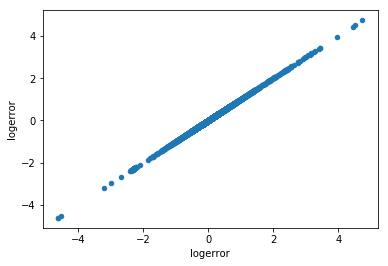

In [8]:
# check for outliers
pd.DataFrame(dl.get_training_preprocessed()['logerror']).plot.scatter(x='logerror', y='logerror')

In [ ]:
summarize(pd.DataFrame(dl.get_training()['logerror']))

In [13]:
# see if logerror varies per month

txm = 'transaction_month'
df = dl.get_training_preprocessed()

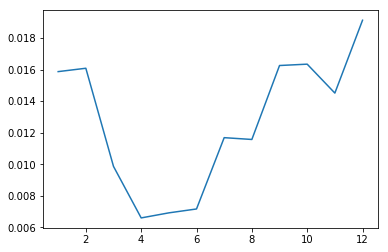

In [14]:
monthly = df[[txm, 'logerror']].groupby([txm])['logerror'].mean()
plt.plot(monthly.index, monthly)

In [ ]:
monthly = df[[txm, 'abs_logerror']].groupby([txm])['abs_logerror'].mean()
plt.ylim(0.06, 0.08)
plt.plot(monthly.index, monthly)

In [ ]:
def plot_monthly(df, grp, val):
    monthly = df.groupby([grp, txm])[val].mean()
    figs = len(monthly.index.levels[0])
    f, axes = plt.subplots(figs, 1, figsize=(8, figs*4), sharex=True, sharey=True)
    for g, ax in zip(monthly.index.levels[0], axes):
        plt.subplot(ax)
        plt.plot(monthly[g].index, monthly[g])

In [ ]:
plot_monthly(df, 'fips', 'logerror')

In [ ]:
plot_monthly(df, 'fips', 'abs_logerror')

In [ ]:
plot_monthly(df, 'regionidcounty', 'abs_logerror')

In [ ]:
monthly = df[[txm, 'abs_logerror']].groupby([txm])['abs_logerror'].mean()
monthly = monthly.reset_index()

In [ ]:
from sklearn import linear_model
reg = linear_model.Ridge(alpha = .5)
reg.fit(monthly.drop('abs_logerror', axis=1), monthly['abs_logerror'])
preds = pd.DataFrame([ i for i in range(24)])
preds['abs_logerror'] = reg.predict(preds)

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(monthly.index, monthly['abs_logerror'])
plt.plot(preds.index, preds['abs_logerror'])

In [ ]:
sns.lmplot(x=txm, y="abs_logerror", data=monthly, ci=None, palette="muted")

In [ ]:
from sklearn import linear_model
lm = linear_model.Ridge(alpha = .5)

def regress(df, val):
    monthly = df.groupby(['fips', 'age'])[val].mean()
    preds = pd.DataFrame()
    for f in monthly.index.levels[0]:
        fip = monthly[f].reset_index()
        lm.fit(fip.drop(val, axis=1), fip[val])
        next_months = pd.DataFrame([ i for i in range(13, 25)], columns=['age'])
        next_months[val] = lm.predict(next_months)
        next_months['fips'] = f
#         display(next_months)
        preds = preds.append(next_months)
    preds = preds.append(monthly.reset_index())
    display(preds)

regress(df, 'abs_logerror')